In [1]:
pip install keras_applications 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
#from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
import os
from keras.layers import *

In [6]:
def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    #plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    #plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    #plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')

In [10]:
def get_base_model(model_name,image_size):
    if model_name =='vgg16':
        base_model=VGG16              (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='resnet50':
        base_model=ResNet50           (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='xception':
        base_model=Xception           (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='densenet121':    #done acc = 55% epochs:30
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='mobilenet0.75': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=0.75,input_shape=(image_size,image_size,3))
    if model_name =='mobilenet1.0': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='mobilenetv2':
        base_model=MobileNetV2      (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='inceptionv3':   
        base_model=InceptionV3       (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='inceptionv2':
        base_model=tf.keras.applications.inception_resnet_v2.InceptionResNetV2 (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    return base_model

In [11]:
def train_model(model,dataset,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
    #C:\Users\aokra\Dataset\Messidor\Messidor_DR__Binary_Classification
    dataParam={'messidor': [960,240,2,'Dataset/Messidor/Messidor_DR__Binary_Classification/train',
                            'Dataset/Messidor/Messidor_DR__Binary_Classification/test'],
               'kaggle': [30000,5126,5,'./data/kaggle/train','./data/kaggle/valid'],
               'DDR':   [9851,2503,5,'./data/DDR/train','./data/DDR/valid']} 
    
    train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)          
    valid = ImageDataGenerator()
    train_data=train.flow_from_directory(train_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = True,
                                         batch_size=batch_size)
    valid_data=valid.flow_from_directory(test_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = False,
                                         batch_size=batch_size)

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    #save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=10)
    
    filepath = "/Binary_save_weights/inceptionv2_cab_messidor_weights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc',verbose=1, save_best_only=True, mode='max')

    for layer in base_model.layers:
        layer.trainable = False   
        
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
    model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs1, 
                        workers=2,
                        callbacks=[lr_decay,checkpoint])   
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history=model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs2,
                        workers=2,
                        callbacks=[lr_decay,checkpoint])
    
    score = model.evaluate(valid_data,batch_size = 16)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history,model,valid_data

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"    
loss_fun= 'categorical_crossentropy'  
gpu_num=1
k=5
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=224
classes=2

base_model=get_base_model('inceptionv2',image_size)  
base_in=base_model.input
base_out=base_model.output

#x=Global_attention_block(base_out)
#base_out=Category_attention_block(x,classes,k)

#shape=K.int_shape(base_out)  
x=GlobalAveragePooling2D()(base_out)
out=Dense(classes,activation='softmax')(x)

parallel_model=keras.Model(base_model.input,out)
   
history,model,valid_data=train_model(parallel_model,
                                     'messidor',
                                     image_size,
                                     batch_size,
                                     'inceptionv2',
                                     lr1,lr2,1,80)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
60/60 [==============================] - ETA: 0s - loss: 65.1840 - acc: 0.5437
Epoch 00001: acc improved from -inf to 0.54375, saving model to /Binary_save_weights\inceptionv2_cab_messidor_weights.hdf5
60/60 [==============================] - 179s 3s/step - loss: 65.1840 - acc: 0.5437
Epoch 1/80
60/60 [==============================] - ETA: 0s - loss: 0.6799 - acc: 0.6458 
Epoch 00001: acc improved from 0.54375 to 0.64583, saving model to /Binary_save_weights\inceptionv2_cab_messidor_weights.hdf5
60/60 [==============================] - 954s 16s/step - loss: 0.6799 - acc: 0.6458
Epoch 2/80
60/60 [==============================] - ETA: 0s - loss: 0.5324 - acc: 0.7437 
Epoch 00002: acc improved from 0.64583 to 0.74375, saving model to /Binary_save_weights\inceptionv2_cab_messidor_weights.hdf5
60/60 [==============================] - 977s 16s/step - loss: 0.5324 - acc: 0.7437
Epoch 3/80
60/60 [==============

Epoch 29/80
60/60 [==============================] - ETA: 0s - loss: 0.0854 - acc: 0.9667 
Epoch 00029: acc did not improve from 0.96979
60/60 [==============================] - 1085s 18s/step - loss: 0.0854 - acc: 0.9667
Epoch 30/80
60/60 [==============================] - ETA: 0s - loss: 0.0593 - acc: 0.9750 
Epoch 00030: acc improved from 0.96979 to 0.97500, saving model to /Binary_save_weights\inceptionv2_cab_messidor_weights.hdf5
60/60 [==============================] - 1093s 18s/step - loss: 0.0593 - acc: 0.9750
Epoch 31/80
60/60 [==============================] - ETA: 0s - loss: 0.0816 - acc: 0.9656 
Epoch 00031: acc did not improve from 0.97500
60/60 [==============================] - 1084s 18s/step - loss: 0.0816 - acc: 0.9656
Epoch 32/80
60/60 [==============================] - ETA: 0s - loss: 0.0589 - acc: 0.9844 
Epoch 00032: acc improved from 0.97500 to 0.98438, saving model to /Binary_save_weights\inceptionv2_cab_messidor_weights.hdf5
60/60 [==============================

Epoch 62/80
60/60 [==============================] - ETA: 0s - loss: 0.0134 - acc: 0.9979 
Epoch 00062: acc did not improve from 1.00000
60/60 [==============================] - 886s 15s/step - loss: 0.0134 - acc: 0.9979
Epoch 63/80
60/60 [==============================] - ETA: 0s - loss: 0.0082 - acc: 0.9979 
Epoch 00063: acc did not improve from 1.00000
60/60 [==============================] - 883s 15s/step - loss: 0.0082 - acc: 0.9979
Epoch 64/80
60/60 [==============================] - ETA: 0s - loss: 0.0207 - acc: 0.9969 
Epoch 00064: ReduceLROnPlateau reducing learning rate to 1.6777214477770033e-05.

Epoch 00064: acc did not improve from 1.00000
60/60 [==============================] - 881s 15s/step - loss: 0.0207 - acc: 0.9969
Epoch 65/80
60/60 [==============================] - ETA: 0s - loss: 0.0067 - acc: 1.0000 
Epoch 00065: acc did not improve from 1.00000
60/60 [==============================] - 885s 15s/step - loss: 0.0067 - acc: 1.0000
Epoch 66/80
60/60 [===============

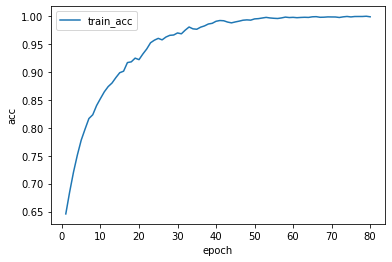

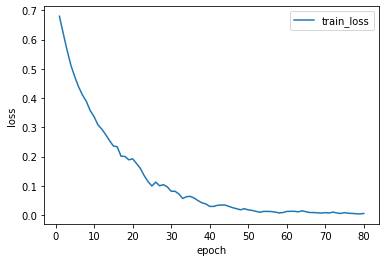

In [15]:
plotmodel(history,'inceptionv2_baseline')         

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[1.95308961e-03 9.98046875e-01]
 [1.89500224e-06 9.99998093e-01]
 [1.00000000e+00 1.79979032e-21]
 [1.00000000e+00 6.93960202e-15]
 [9.99998689e-01 1.33236085e-06]
 [7.50644684e-01 2.49355316e-01]
 [9.87557530e-01 1.24424621e-02]
 [9.99999762e-01 2.01446696e-07]
 [9.99009013e-01 9.90995904e-04]
 [1.00000000e+00 2.75995685e-11]
 [9.04503047e-01 9.54970047e-02]
 [9.32112217e-01 6.78878576e-02]
 [3.56478118e-08 1.00000000e+00]
 [3.69814456e-01 6.30185544e-01]
 [9.56606627e-01 4.33933437e-02]
 [2.54072147e-05 

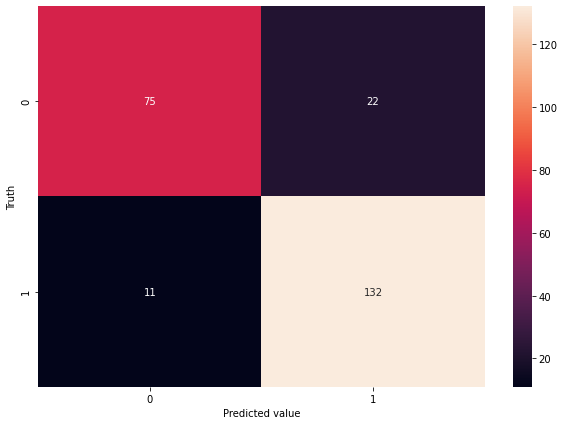

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

Y_pred = model.predict(valid_data, 240 // 4)
#print(Y_pred.shape)
#print(type(Y_pred))
print(valid_data.classes)  
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)
print('Confusion Matrix')
matrix = confusion_matrix(valid_data.classes, y_pred)

print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = ['non-referable', 'referable']
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

plt.figure(figsize = (10,7))
sn.heatmap(matrix,annot=True,fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Truth')   
plt.savefig('confusion_matrix_inceptionv2_baseline.png')

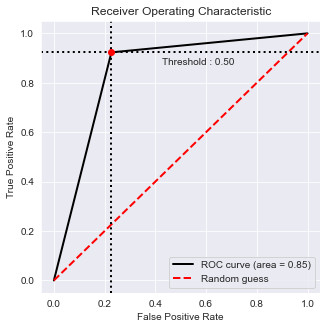

In [17]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
y_true = valid_data.classes
y_probas = y_pred
bc = BinaryClassification(y_true, y_probas, labels=['non-referable', 'referable'])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()